**Scene Regonization**

- Load dataset using Imagefolder
- Slpit the dataset in to tarin and validation set (ratio 80 - 20)
- Data Augmenatation
- Training Resnet34 model
- Calculating the confusion matrix and classification report
- Test set validation 


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

In [ ]:
#Data Augmentation

transforms =   transforms.Compose([
        transforms.Resize((224, 224)), #resizing the image from 128x128 to 224x224
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        #ransforms.RandomAffine(degrees=5, translate=None, scale=(1, 2), shear=15),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))#mean and standard deviation
])

In [ ]:
#Loading the datastet and applying data augmentation
img = datasets.ImageFolder(root='/content/drive/MyDrive/AML/Places2_simp', transform=transforms) #folder path of dataset
train_len = int(len(img) * 0.8)
valid_len = len(img) - train_len
train_dataset, val_dataset = torch.utils.data.random_split(img, [train_len, valid_len]) #randomly spliting the dataset 

In [ ]:
#Train Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
#validation dataloader
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True)

Label: tensor(33)


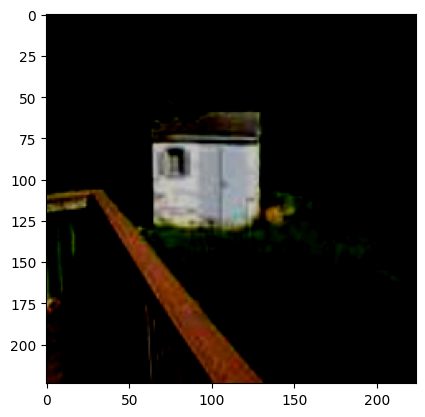

In [ ]:
# import plot library
import matplotlib.pyplot as plt
# iterate the dataloader
images, labels = next(iter(train_dataloader))

# show the data
plt.imshow(images[1].permute(1, 2, 0))
print("Label: " + str(labels[1]))

**Model Training**

model - resnet34 (pre-trained)

learning rate - 0.0001

weight - 0.0005

optimizer - Adam

Number of classes 40

Epoch - 5


In [ ]:
model = models.resnet34(pretrained=True)
if torch.cuda.is_available():
    device = torch.device("cuda")
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)
else:
    device = torch.device("cpu")
model = model.to(device)
# Freeze the weights of the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Define the new layers
num_ftrs = model.fc.in_features
new_layers = nn.Sequential(
    nn.Linear(num_ftrs, 128).to(device),
    nn.ReLU(),
    nn.Linear(128, 40).to(device)
)


# Concatenate the pre-trained layers with the new layers
model.fc = new_layers
# Set the requires_grad attribute of the new layers to True
for param in model.fc.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
## create model and optimizer
learning_rate = 0.0001
weight_decay = 0.0005
# define optimizer
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate, weight_decay=weight_decay)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 87.9MB/s]


In [ ]:
!nvidia-smi

Tue May 23 19:04:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    26W /  70W |    707MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#!pip install torchsummary
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
n_epochs = 5
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    #model.train()
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (val_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = model(data_t.to(device))
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(val_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
    model.train()

Epoch 1

Epoch [1/5], Step [0/250], Loss: 3.7343
Epoch [1/5], Step [20/250], Loss: 3.6685
Epoch [1/5], Step [40/250], Loss: 3.6269
Epoch [1/5], Step [60/250], Loss: 3.5982
Epoch [1/5], Step [80/250], Loss: 3.5236
Epoch [1/5], Step [100/250], Loss: 3.4300
Epoch [1/5], Step [120/250], Loss: 3.3886
Epoch [1/5], Step [140/250], Loss: 3.2807
Epoch [1/5], Step [160/250], Loss: 3.2951
Epoch [1/5], Step [180/250], Loss: 3.1080
Epoch [1/5], Step [200/250], Loss: 3.0190
Epoch [1/5], Step [220/250], Loss: 2.9212
Epoch [1/5], Step [240/250], Loss: 2.9426

train-loss: 3.3273, train-acc: 20.4613
validation loss: 2.8581, validation acc: 37.8541

Epoch 2

Epoch [2/5], Step [0/250], Loss: 2.8615
Epoch [2/5], Step [20/250], Loss: 2.7951
Epoch [2/5], Step [40/250], Loss: 2.7875
Epoch [2/5], Step [60/250], Loss: 2.6934
Epoch [2/5], Step [80/250], Loss: 2.5058
Epoch [2/5], Step [100/250], Loss: 2.5719
Epoch [2/5], Step [120/250], Loss: 2.3785
Epoch [2/5], Step [140/250], Loss: 2.4131
Epoch [2/5], Step [160

Training Accuracy is 50.98

Validation Accuracy is 50.38

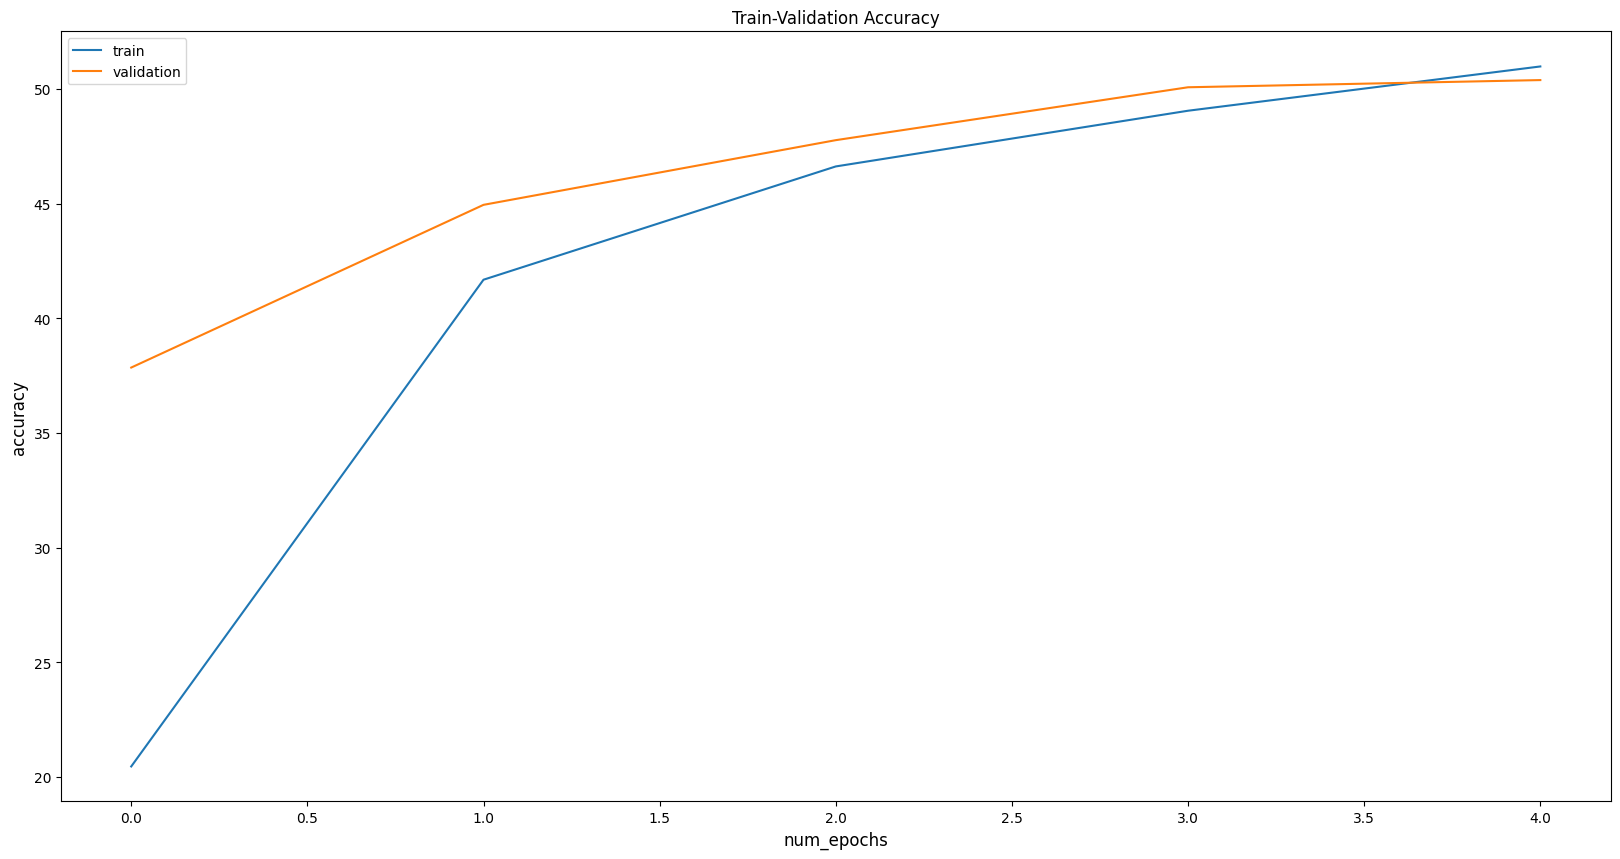

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

Classification Report and Confusion Matrix

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix

# Define your model, loss function, optimizer, and other necessary components

def evaluate(model, data_loader, device):
    model.eval()
    predicted_labels = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predicted_labels, true_labels

In [ ]:
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
validation_predicted_labels, validation_true_labels = evaluate(model, val_dataloader, device)
validation_classification_report = classification_report(validation_true_labels, validation_predicted_labels)
validation_confusion_matrix = confusion_matrix(validation_true_labels, validation_predicted_labels)


Loading test dataset

In [ ]:

test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/AML/testset', transform=transforms.Compose([transforms.ToTensor()]))
#dataloader
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
test_predicted_labels, test_true_labels = evaluate(model, test_dataloader, device)


test_classification_report = classification_report(test_true_labels, test_predicted_labels)
test_confusion_matrix = confusion_matrix(test_true_labels, test_predicted_labels)



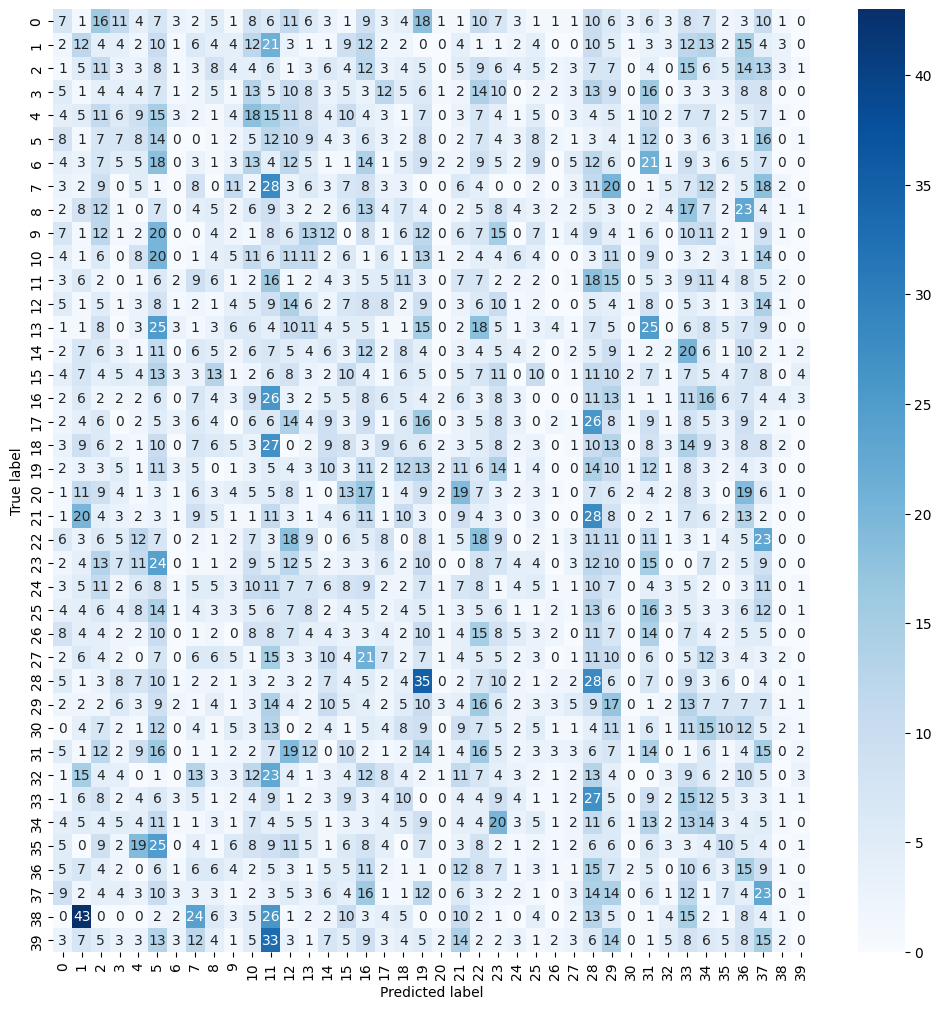

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Compute the confusion matrix
confusion_matrix = test_confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
#plot_confusion_matrix(lr,test_texts,test_labels)
figure = plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True,fmt='d',cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

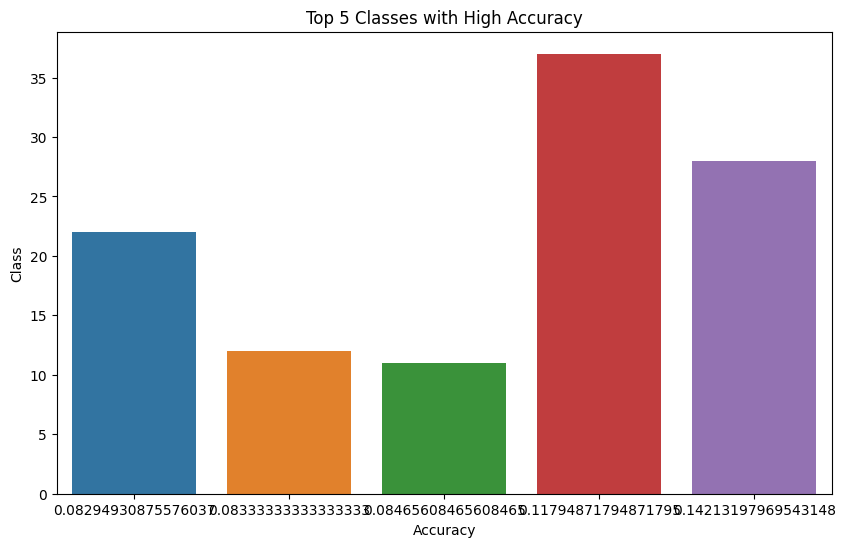

[28 37 11 12 22 29 36 33  5 34 19 31  1 10  2 35 13 15 21  4  7 16 23  0
 14 18  8 24  3 32 26 20  9 25 27 30 17 38  6 39]


In [ ]:
# Calculate the accuracy for each class
class_accuracy = confusion_matrix.diagonal() / confusion_matrix.sum(axis=1)

# Sort the classes based on accuracy in descending order
sorted_classes = np.argsort(class_accuracy)[::-1]

# Get the top 5 classes with the highest accuracy
top_classes = sorted_classes[:5]

# Get the corresponding accuracy values for the top classes
top_accuracy = class_accuracy[top_classes]

# Plot the top classes and their accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x=top_accuracy, y=top_classes)
plt.title('Top 5 Classes with High Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Class')
plt.show()
print(sorted_classes)